In [1]:
import tensorflow as tf
import numpy as np
import cv2

In [2]:
MEMORY_LIMIT = 1024
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf
.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_LIMIT)])
    except RuntimeError as e:
        print(e)

In [3]:
IMG_SIZE = 32
NUM_CLASSES = 5

### Define model skeleton

In [4]:
def build_model(IMG_SIZE, NUM_CLASSES):
    x_input = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x_input)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu', use_bias='True', 
                   kernel_initializer = tf.keras.initializers.VarianceScaling())(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid', use_bias='False', 
                   kernel_initializer = tf.keras.initializers.VarianceScaling())(x)

    model = tf.keras.Model(inputs=x_input, outputs=x)
    model.compile(optimizer='Adam', 
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy']
             )
    return model

### Build model

In [5]:
model = build_model(IMG_SIZE, NUM_CLASSES)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0     

### splitting train into train and validate

In [9]:
import os
import shutil

base = 'Gestures/'
src = base + 'train/'
dest = base + 'validate/'

for d in os.listdir(src):
    moved = 0
    for i in os.listdir(src + d):
        if np.random.rand() < 0.05:
            shutil.move(src + d + '/' + i, dest + d + '/' + i)
            moved += 1
    print(d, ": {} files moved to validate".format(moved))

asl_f : 217 files moved to validate
palm : 210 files moved to validate
garbage : 82 files moved to validate
seven : 240 files moved to validate
fist : 229 files moved to validate


In [10]:
# Moving all files back to train
# for d in os.listdir(dest):
#     for i in os.listdir(dest + d):
#         shutil.move(dest + d + '/' + i, src + d + '/' + i)

### Data generation and preprocessing

Automatically generate data from directory structure

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    './Gestures/train',
    color_mode='grayscale',
    target_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    batch_size=128,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    './Gestures/validate',
    color_mode='grayscale',
    target_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    batch_size=128,
    class_mode='categorical'
)

Found 18297 images belonging to 5 classes.
Found 978 images belonging to 5 classes.


### Fitting the model

In [12]:
STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n // validation_generator.batch_size

print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)
hist = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID
)

# model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=20)

142 7
Epoch 1/10
142/142 [==============================] - 97s 686ms/step - loss: 0.1795 - accuracy: 0.9533 - val_loss: 3.2054 - val_accuracy: 0.2132
Epoch 2/10
142/142 [==============================] - 36s 255ms/step - loss: 0.0381 - accuracy: 0.9905 - val_loss: 6.9133 - val_accuracy: 0.1038
Epoch 3/10
142/142 [==============================] - 39s 273ms/step - loss: 0.0272 - accuracy: 0.9925 - val_loss: 2.4021 - val_accuracy: 0.5826
Epoch 4/10
142/142 [==============================] - 40s 283ms/step - loss: 0.0190 - accuracy: 0.9945 - val_loss: 0.1192 - val_accuracy: 0.9643
Epoch 5/10
142/142 [==============================] - 40s 284ms/step - loss: 0.0117 - accuracy: 0.9965 - val_loss: 0.0552 - val_accuracy: 0.9888
Epoch 6/10
142/142 [==============================] - 39s 275ms/step - loss: 0.0115 - accuracy: 0.9966 - val_loss: 0.0428 - val_accuracy: 0.9944
Epoch 7/10
142/142 [==============================] - 39s 276ms/step - loss: 0.0120 - accuracy: 0.9968 - val_loss: 0.0043 - 

In [13]:
# model.save('saved_model')
model.save('saved_model2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model2/assets


### Learning curve

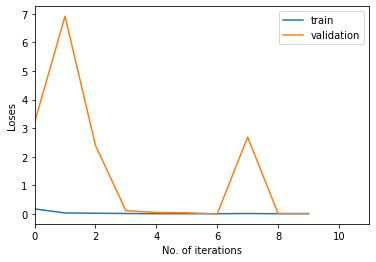

In [16]:
from matplotlib import pyplot as plt
plt.plot(hist.epoch, hist.history['loss'], label='train')
plt.plot(hist.epoch, hist.history['val_loss'], label='validation')
plt.xlabel('No. of iterations')
plt.ylabel('Loses')
plt.xlim(0, len(hist.epoch)+1)
plt.legend()
plt.show()